# ANALYSIS ON CHICAGO CITY TRAFFIC CONGESTION ESTIMATES AND CRASHES DATA

##### Team 14
#### John Olusetire G01422053 joluseti@gmu.edu 
#### Timothy Obuadey G01235035 tobuadey@gmu.edu 
#### Anand Seshadri G00929994 aseshadr@gmu.eddu
###### Traffic Crash Data Source - https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data
###### Traffic Congestion Data Source - https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Historical-Congestion-Esti/kf7e-cur8/about_data

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Import Spark And All Third Party Libraries##

In [2]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()
print(sc.version)
print(spark.version)

2.4.7
2.4.7


In [3]:
#Third Party Libraries Mainly Used For Data Visualization
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd
import plotly.express as px
from shapely.geometry import Polygon

from pyspark.sql.types import *
from pyspark.sql.functions import *

### Read The Data From Parquet Files

In [4]:
#READ DATA FROM PARQUET FILES
traffic_data = spark.read.parquet("C:/BigData/~userData/proj/congest.parquet")
crashes_data = spark.read.parquet("C:/BigData/~userData/proj/crashes.parquet")

### Write the data to MongoDB

In [5]:
traffic_data.write.format("mongo").mode("ignore").option("uri","mongodb://127.0.0.1:27018/project.chicagoCongestionData").save()
crashes_data.write.format("mongo").mode("ignore").option("uri","mongodb://127.0.0.1:27018/project.chicagoAccidentData").save()

### Read Data From MongoDB

In [6]:
# READ DATA FROM MONGODB
crashes_df = spark.read.format("mongo").option("uri","mongodb://127.0.0.1:27018/project.chicagoAccidentData").load()
traffic_df = spark.read.format("mongo").option("uri","mongodb://127.0.0.1:27018/project.chicagoCongestionData").load()

### Print Data Schema

In [8]:
crashes_df.printSchema()
traffic_df.printSchema()

root
 |-- ALIGNMENT: string (nullable = true)
 |-- BEAT_OF_OCCURRENCE: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- CRASH_DATE_EST_I: string (nullable = true)
 |-- CRASH_DAY_OF_WEEK: string (nullable = true)
 |-- CRASH_HOUR: string (nullable = true)
 |-- CRASH_MONTH: string (nullable = true)
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- DOORING_I: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- HIT_AND_RUN_I: string (nullable = true)
 |-- INJURIES_FATAL: string (nullable = true)
 |-- INJURIES_INCAPACITATING: string (nullable = true)
 |-- INJURIES_NON_INCAPACITATING: string (nullable = true)
 |-- INJURIES_NO_INDICATION: string (nullable = true)
 |-- INJURIES_REPORTED_NOT_EVIDENT: string (nullable = true)
 |-- INJURIES_TOTAL: string (nullable = true

### Extract Columns We will be working with from dataframes

In [15]:
# Extract Relevant Columns from data 
# tdf = Traffic/Congestion Dataframe; cdf = crashes/accident dataframe

tdf = traffic_data.select("TIME", "REGION_ID", "REGION", "NORTH", "EAST", "SOUTH", "WEST", "SPEED", "BUS_COUNT", "NUM_READS", "HOUR", "DAY_OF_WEEK")
cdf = crashes_data.select("CRASH_DATE", "LATITUDE", "LONGITUDE", "CRASH_HOUR", "CRASH_DAY_OF_WEEK", "FIRST_CRASH_TYPE","PRIM_CONTRIBUTORY_CAUSE",  "WEATHER_CONDITION", "ROADWAY_SURFACE_COND", "LIGHTING_CONDITION")

In [10]:
tdf.printSchema()
cdf.printSchema()

root
 |-- TIME: string (nullable = true)
 |-- REGION_ID: string (nullable = true)
 |-- REGION: string (nullable = true)
 |-- NORTH: string (nullable = true)
 |-- EAST: string (nullable = true)
 |-- SOUTH: string (nullable = true)
 |-- WEST: string (nullable = true)
 |-- SPEED: string (nullable = true)
 |-- BUS_COUNT: string (nullable = true)
 |-- NUM_READS: string (nullable = true)
 |-- HOUR: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)

root
 |-- CRASH_DATE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- CRASH_HOUR: string (nullable = true)
 |-- CRASH_DAY_OF_WEEK: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- PRIM_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)



In [16]:
#Correct data type for particular columns
tdf = tdf.withColumn("TIME", to_timestamp('TIME', 'MM/dd/yyyy hh:mm:ss a')) \
            .withColumn('SPEED', round(col('SPEED'))) \
            .withColumn("REGION_ID", tdf.REGION_ID.cast(IntegerType())) \
            .withColumn("NORTH", tdf.NORTH.cast(DoubleType())) \
            .withColumn("EAST", tdf.EAST.cast(DoubleType())) \
            .withColumn("SOUTH", tdf.SOUTH.cast(DoubleType())) \
            .withColumn("WEST", tdf.WEST.cast(DoubleType())) \
            .withColumn("BUS_COUNT", tdf.BUS_COUNT.cast(IntegerType())) \
            .withColumn("NUM_READS", tdf.NUM_READS.cast(IntegerType())) \
            .withColumn("HOUR", tdf.HOUR.cast(IntegerType())) \
            .withColumn("DAY_OF_WEEK", tdf.DAY_OF_WEEK.cast(IntegerType())) \

cdf = cdf.withColumn("CRASH_DATE", to_timestamp('CRASH_DATE', 'MM/dd/yyyy hh:mm:ss a')) \
            .withColumn("LATITUDE", cdf.LATITUDE.cast(DoubleType())) \
            .withColumn("LONGITUDE", cdf.LONGITUDE.cast(DoubleType())) \
            .withColumn("CRASH_HOUR", cdf.CRASH_HOUR.cast(IntegerType())) \
            .withColumn("CRASH_DAY_OF_WEEK", cdf.CRASH_DAY_OF_WEEK.cast(IntegerType())) \

In [12]:
#schema with correct data types

tdf.printSchema()
cdf.printSchema()

root
 |-- TIME: timestamp (nullable = true)
 |-- REGION_ID: integer (nullable = true)
 |-- REGION: string (nullable = true)
 |-- NORTH: double (nullable = true)
 |-- EAST: double (nullable = true)
 |-- SOUTH: double (nullable = true)
 |-- WEST: double (nullable = true)
 |-- SPEED: double (nullable = true)
 |-- BUS_COUNT: integer (nullable = true)
 |-- NUM_READS: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)

root
 |-- CRASH_DATE: timestamp (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- CRASH_HOUR: integer (nullable = true)
 |-- CRASH_DAY_OF_WEEK: integer (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- PRIM_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)



### Data Cleanup

In [17]:
#Drop any rows with Null Values
tdf = tdf.dropna()
cdf = cdf.dropna()

In [18]:
#Because we will be doing correlation analysis, the two datasets must have the same start and end dates
tdf.select(min(tdf.TIME).alias("Oldest date (tdf)"),max(tdf.TIME).alias("Latest date (tdf)")).show()
cdf.select(min(cdf.CRASH_DATE).alias("Oldest date (cdf)"),max(cdf.CRASH_DATE).alias("Latest date (cdf)")).show()

+-------------------+-------------------+
|  Oldest date (tdf)|  Latest date (tdf)|
+-------------------+-------------------+
|2018-03-09 15:40:41|2023-11-27 15:22:00|
+-------------------+-------------------+

+-------------------+-------------------+
|  Oldest date (cdf)|  Latest date (cdf)|
+-------------------+-------------------+
|2013-03-03 16:48:00|2023-11-26 22:50:00|
+-------------------+-------------------+



In [19]:
#Drop cdf data before 2018-03-09
rawcdf = cdf
cdf = cdf.filter(col("CRASH_DATE") > "2018-03-09 15:40:41")
cdf.select(min(cdf.CRASH_DATE)).show()

+-------------------+
|    min(CRASH_DATE)|
+-------------------+
|2018-03-09 15:50:00|
+-------------------+



In [20]:
cdf.select(min(cdf.CRASH_DATE).alias("Oldest date (cdf)"),max(cdf.CRASH_DATE).alias("Latest date (cdf)")).show()

+-------------------+-------------------+
|  Oldest date (cdf)|  Latest date (cdf)|
+-------------------+-------------------+
|2018-03-09 15:50:00|2023-11-26 22:50:00|
+-------------------+-------------------+



In [21]:
#Amount of data in dataframes
print(tdf.count(), "rows in traffic congestion dataframe")
print(cdf.count(), "rows in vehicle crashes dataframe")

7593916 rows in traffic congestion dataframe
620481 rows in vehicle crashes dataframe


# Analysis

### Temporal Analysis (hours, days, months)

In [22]:
#Aggregrate by hours of day and check how many times 0 was recorded
#Zero is recorded as average speed when data is unavailable (middle of the night)
#The number of rows with data less than 1 is higher at the 
#This is shown by the low average number of gps reads and low bus counts

tdf.groupBy("HOUR").agg(
        round(avg("SPEED"), 2).alias("avg_speed"),
        round(avg("BUS_COUNT"), 2).alias("avg_bus_count"),
        round(avg("NUM_READS"), 2).alias("avg_num_reads"),
        count("*").alias("row_count")
    ).sort(asc("HOUR")).show(24, truncate=False)

+----+---------+-------------+-------------+---------+
|HOUR|avg_speed|avg_bus_count|avg_num_reads|row_count|
+----+---------+-------------+-------------+---------+
|0   |25.29    |13.71        |281.82       |315882   |
|1   |21.53    |8.87         |174.04       |316413   |
|2   |11.94    |4.9          |86.75        |315549   |
|3   |11.7     |4.5          |79.73        |316558   |
|4   |23.96    |11.29        |222.22       |317144   |
|5   |26.58    |22.45        |479.26       |316124   |
|6   |26.44    |37.88        |779.32       |316269   |
|7   |24.95    |49.84        |1019.37      |316358   |
|8   |24.48    |52.21        |1069.07      |315253   |
|9   |24.95    |47.71        |972.27       |316047   |
|10  |25.27    |40.08        |850.85       |316444   |
|11  |25.11    |38.0         |820.21       |317538   |
|12  |24.82    |38.57        |829.1        |317663   |
|13  |24.49    |40.68        |855.57       |317321   |
|14  |24.15    |44.91        |919.47       |317780   |
|15  |23.5

In [23]:
#Aggregrate by hours of day and check how many times SPEED < 1 was recorded
#Zero is recorded as average speed when data is unavailable (middle of the night)
#The number of rows with data less than 1 is higher at the 
#This is shown by the low average number of gps reads and low bus counts
#Most speeds less than one are recorded due to inadequate data, so not using those rows will help for better analysis

tdf.filter(col("SPEED") < 1).groupBy("HOUR").agg(
        round(avg("BUS_COUNT"), 2).alias("avg_bus_count"),
        round(avg("NUM_READS"), 2).alias("avg_num_reads"),
        count("*").alias("row_count")
    ).sort(asc("HOUR")).show(24, truncate=False)

+----+-------------+-------------+---------+
|HOUR|avg_bus_count|avg_num_reads|row_count|
+----+-------------+-------------+---------+
|0   |2.83         |58.93        |29021    |
|1   |2.62         |49.42        |79293    |
|2   |2.36         |42.32        |185178   |
|3   |2.15         |39.82        |190931   |
|4   |2.69         |49.0         |58153    |
|5   |2.96         |68.49        |14048    |
|6   |3.16         |77.47        |4500     |
|7   |2.03         |53.0         |5013     |
|8   |1.45         |37.45        |7092     |
|9   |1.23         |35.75        |7192     |
|10  |1.73         |39.74        |5907     |
|11  |1.71         |45.16        |4755     |
|12  |1.83         |47.35        |4044     |
|13  |1.71         |45.25        |4431     |
|14  |1.74         |44.33        |4677     |
|15  |1.58         |39.26        |5497     |
|16  |1.65         |41.94        |5278     |
|17  |1.69         |41.68        |5406     |
|18  |1.66         |43.72        |5897     |
|19  |2.03

In [24]:
# Make 2 dataframes one using all the data and one using data that staisfies SPEED >= 1

temp1 = tdf.filter(col("SPEED") >= 1).groupBy("HOUR").agg(round(avg("SPEED"), 2).alias("Average Speed")).sort(asc("HOUR"))

temp2 = tdf.groupBy("HOUR").agg(round(avg("SPEED"), 2).alias("Average Speed")).sort(asc("HOUR"))

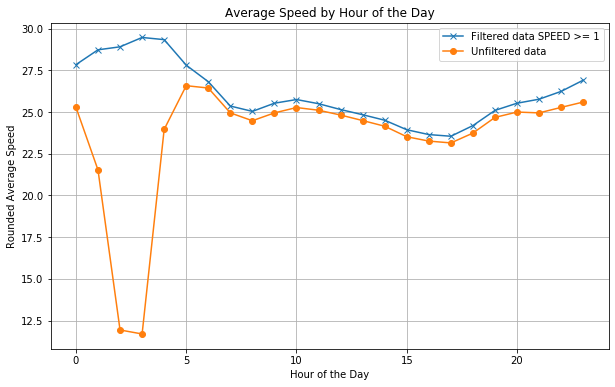

In [25]:
local_data_temp1 = temp1.toPandas()
local_data_temp2 = temp2.toPandas()

# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(local_data_temp1["HOUR"], local_data_temp1["avg_speed"], marker='x', label='Filtered data SPEED >= 1')
plt.plot(local_data_temp2["HOUR"], local_data_temp2["avg_speed"], marker='o', label='Unfiltered data ')


plt.xlabel("Hour of the Day")
plt.ylabel("Rounded Average Speed")
plt.title("Average Speed by Hour of the Day")
plt.legend()
plt.grid(True)
plt.show()

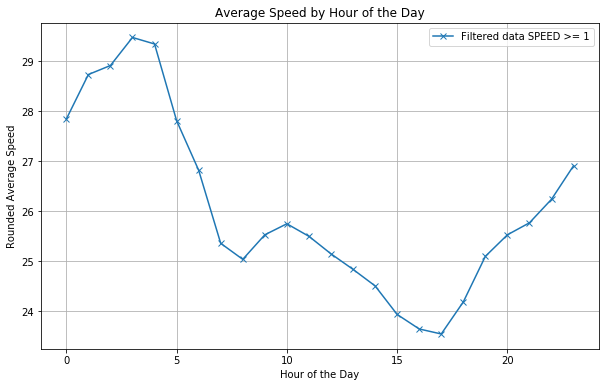

In [26]:
# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(local_data_temp1["HOUR"], local_data_temp1["avg_speed"], marker='x', label='Filtered data SPEED >= 1')

plt.xlabel("Hour of the Day")
plt.ylabel("Rounded Average Speed")
plt.title("Average Speed by Hour of the Day")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
#now that we know the effect SPEED < 1 has on the data, i will filter it out from our dataframe

rawtdf = tdf  #store old tdf before filtering
tdf = tdf.filter(col("SPEED") >= 1)  #filter tdf to remove any row with SPEED < 1

In [28]:
#Group by day, check avg speed for each day of the week. Day 1 is Sunday

tempdf1 = tdf.groupBy("DAY_OF_WEEK").agg(round(avg("SPEED"), 2).alias("Average Speed")).sort(asc("DAY_OF_WEEK"))
tempdf1.show(7, truncate = False)

+-----------+-------------+
|DAY_OF_WEEK|Average Speed|
+-----------+-------------+
|1          |26.94        |
|2          |25.61        |
|3          |25.51        |
|4          |25.46        |
|5          |25.47        |
|6          |25.49        |
|7          |26.4         |
+-----------+-------------+



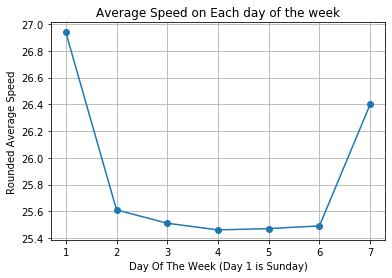

In [29]:
#GRAPH SHOWCASES LESS CONGESTION ON WEEKENDS

local_data1 = tempdf1.toPandas()

# Plot the data using Matplotlib
plt.plot(local_data1["DAY_OF_WEEK"], local_data1["Average Speed"], marker='o')
plt.xlabel("Day Of The Week (Day 1 is Sunday)")
plt.ylabel("Rounded Average Speed")
plt.title("Average Speed on Each day of the week")
plt.grid(True)
plt.show()

In [30]:
##Month by month analysis

tempdf2 = (tdf
    .groupBy(month("TIME").alias("MONTH"))
    .agg(round(avg("SPEED"), 2).alias("Average Speed"))
    .sort("MONTH")
)
tempdf2.show(12, truncate=False)

+-----+-------------+
|MONTH|Average Speed|
+-----+-------------+
|1    |25.66        |
|2    |25.72        |
|3    |25.76        |
|4    |25.83        |
|5    |25.87        |
|6    |25.77        |
|7    |25.89        |
|8    |25.85        |
|9    |25.81        |
|10   |25.76        |
|11   |26.14        |
|12   |25.92        |
+-----+-------------+



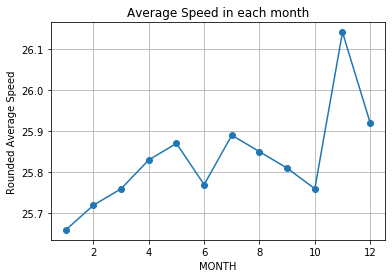

In [32]:
local_data2 = tempdf2.toPandas()

# Plot the data using Matplotlib
plt.plot(local_data2["MONTH"], local_data2["Average Speed"], marker='o')
plt.xlabel("MONTH")
plt.ylabel("Rounded Average Speed")
plt.title("Average Speed in each month")
plt.grid(True)
plt.show()

### Region Analysis

In [33]:
## Showcases the data for each of the 29 regions, average bus count, number of reads, average speed
regiontdf = tdf.groupBy("REGION_ID", "REGION").agg(
        round(avg("SPEED"), 2).alias("avg_speed"),
        round(avg("BUS_COUNT"), 2).alias("avg_bus_count"),
        round(avg("NUM_READS"), 2).alias("avg_num_reads"),
        count("*").alias("row_count")
    ).sort(asc("REGION_ID"))

regiontdf.show(29, truncate=False)

+---------+---------------------------------+---------+-------------+-------------+---------+
|REGION_ID|REGION                           |avg_speed|avg_bus_count|avg_num_reads|row_count|
+---------+---------------------------------+---------+-------------+-------------+---------+
|1        |Rogers Park - West Ridge         |24.15    |21.73        |445.51       |224459   |
|2        |Far North West                   |28.64    |30.44        |593.48       |245730   |
|3        |North Park-Albany-Linconl Sq     |24.09    |45.45        |891.5        |255050   |
|4        |Edge Water-Uptown                |22.35    |32.25        |636.9        |235467   |
|5        |Dunning-Portage-Belmont Cragn    |25.21    |45.58        |1100.36      |237615   |
|6        |Irving Park-Avondale-North Ctr   |23.82    |39.03        |883.07       |248084   |
|7        |Hermosa-Logan Square             |23.44    |38.03        |779.23       |240127   |
|8        |Lincoln Park-Lake View           |22.21    |59.02

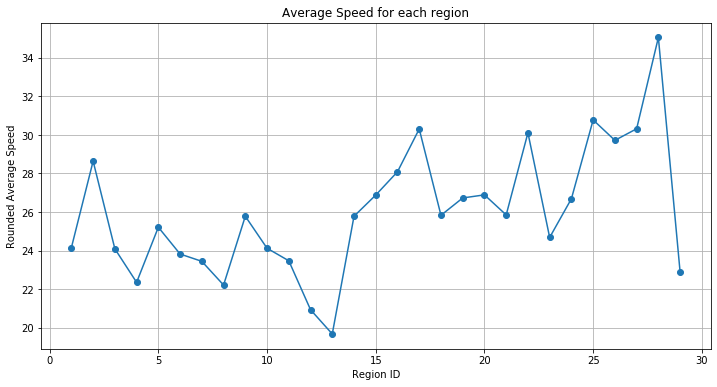

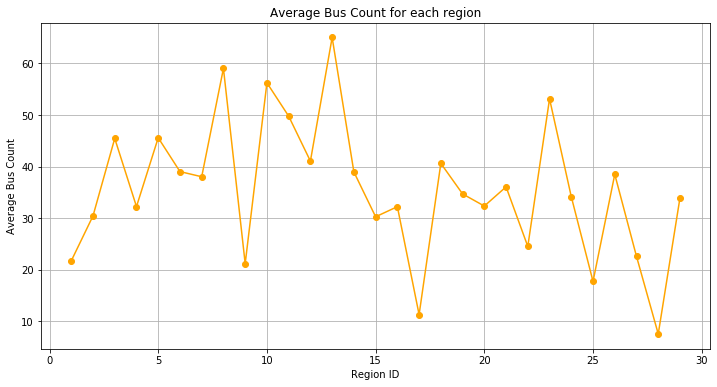

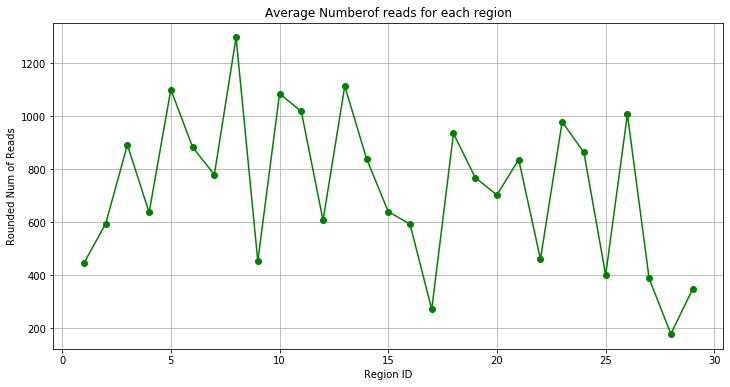

In [34]:
## Plots to show relationship between this variables

local_data = regiontdf.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(local_data["REGION_ID"], local_data["avg_speed"], marker='o')
plt.xlabel("Region ID")
plt.ylabel("Rounded Average Speed")
plt.title("Average Speed for each region")
plt.grid(True)
plt.show()

local_data = regiontdf.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(local_data["REGION_ID"], local_data["avg_bus_count"], marker='o', color="orange")
plt.xlabel("Region ID")
plt.ylabel("Average Bus Count")
plt.title("Average Bus Count for each region")
plt.grid(True)
plt.show()

local_data = regiontdf.toPandas()
plt.figure(figsize=(12, 6))
plt.plot(local_data["REGION_ID"], local_data["avg_num_reads"], marker='o', color="green")
plt.xlabel("Region ID")
plt.ylabel("Rounded Num of Reads")
plt.title("Average Number of reads for each region")
plt.grid(True)
plt.show()

In [35]:
# Need to scale data before plotting them together. Using MinMax scaler

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
metrics_cols = ["avg_speed", "avg_bus_count", "avg_num_reads"]


assembler = VectorAssembler(inputCols=metrics_cols, outputCol="features")
df_assembled = assembler.transform(regiontdf)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
scaled_df = scaler_model.transform(df_assembled)

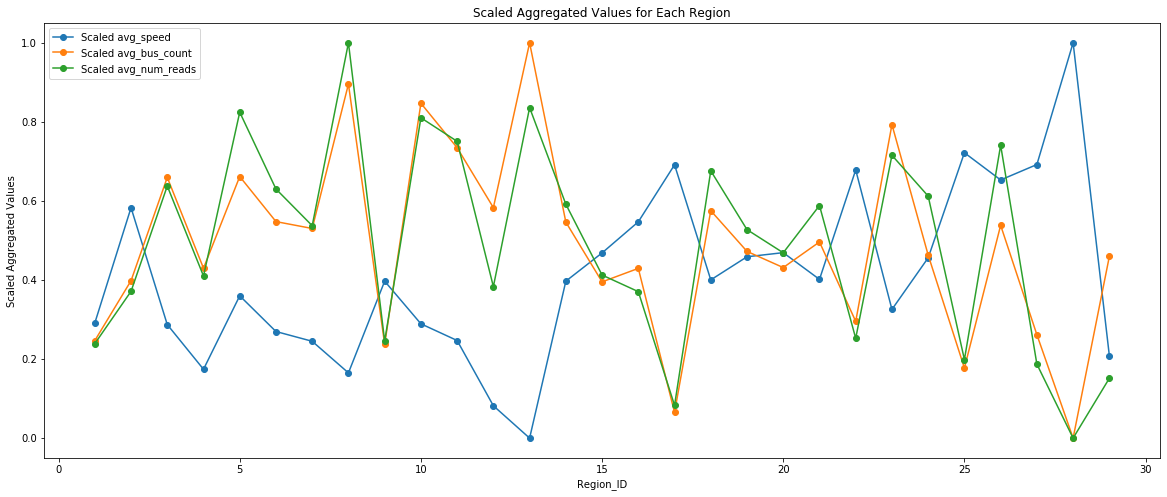

In [39]:
# Convert the DataFrame to Pandas for plotting
pandas_df = scaled_df.select("REGION_ID", "scaled_features").toPandas()
plt.figure(figsize=(20, 8))

# Plot the scaled aggregated values for each region
for i, metric in enumerate(metrics_cols):
    plt.plot(pandas_df["REGION_ID"], pandas_df["scaled_features"].apply(lambda x: x[i]), label=f"Scaled {metric}", marker='o')


plt.xlabel("Region_ID")
plt.ylabel("Scaled Aggregated Values")
plt.title("Scaled Aggregated Values for Each Region")
plt.legend()
plt.show()

### Geospatial Visualization

In [37]:
## Get dataframe with boundary coordinates
temp_tdf = tdf.groupBy("REGION_ID", "REGION", "NORTH", "EAST", "SOUTH", "WEST").agg(
        round(avg("SPEED"), 2).alias("Average Speed"),
    ).sort(asc("REGION_ID"))

temp_tdf.show(2, truncate=False)

+---------+------------------------+----------+----------+---------+----------+---------+
|REGION_ID|REGION                  |NORTH     |EAST      |SOUTH    |WEST      |avg_speed|
+---------+------------------------+----------+----------+---------+----------+---------+
|1        |Rogers Park - West Ridge|42.026444 |-87.654561|41.997946|-87.709645|24.15    |
|2        |Far North West          |42.0190998|-87.747456|41.960669|-87.84621 |28.64    |
+---------+------------------------+----------+----------+---------+----------+---------+
only showing top 2 rows



In [40]:
## Create geodataframe for visualization on a map

geo_tdf = gpd.GeoDataFrame(
    temp_tdf.toPandas(),
    geometry=[
        Polygon([(row['WEST'], row['NORTH']),
                 (row['EAST'], row['NORTH']),
                 (row['EAST'], row['SOUTH']),
                 (row['WEST'], row['SOUTH']),
                 (row['WEST'], row['NORTH'])])
        for _, row in temp_tdf.toPandas().iterrows()
    ]
)

geo_tdf.drop(["NORTH", "EAST", "SOUTH", "WEST"], inplace= True, axis=1)
geo_tdf.set_crs(epsg = "4326", inplace = True)
geo_tdf.head()

,REGION_ID,REGION,avg_speed,geometry
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026..."
1,2,Far North West,28.64,"POLYGON ((-87.84621 42.01910, -87.74746 42.019..."
2,3,North Park-Albany-Linconl Sq,24.09,"POLYGON ((-87.74746 41.99795, -87.67459 41.997..."
3,4,Edge Water-Uptown,22.35,"POLYGON ((-87.67459 41.99795, -87.64644 41.997..."
4,5,Dunning-Portage-Belmont Cragn,25.21,"POLYGON ((-87.84621 41.96067, -87.74746 41.960..."


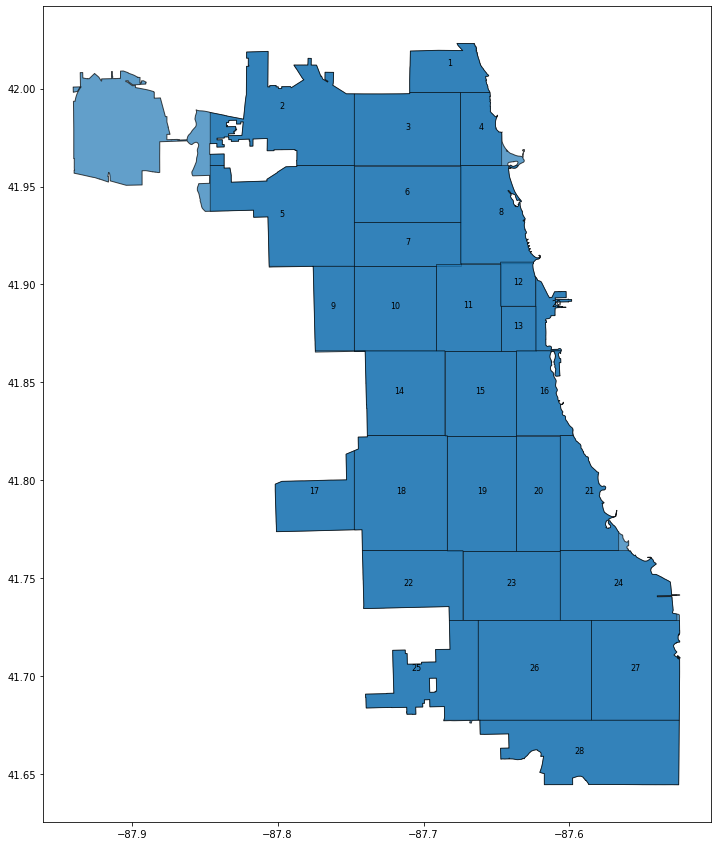

In [41]:
##Basically the boundaries of our dataset are rectangular, to plot it on the chicago map accurately, 
#an overlay of the data boundaries and an actual map is needed
## Chicago city map plot showing regions

basemap_shapefile_path = 'boundaries/chicago.shp'   #chicago shapefile for plot boundaries

# Load the basemap shapefile into a GeoDataFrame
basemap_gdf = gpd.read_file(basemap_shapefile_path)


geo_tdf = geo_tdf.to_crs(basemap_gdf.crs)
#geo_tdf = geo_tdf.to_crs("EPSG:32616")

#Get Overlay
overlay_result = gpd.overlay(basemap_gdf, geo_tdf, how='intersection')

# Plot the basemap
ax = basemap_gdf.plot(edgecolor='black', linewidth=1, alpha=0.7, figsize=(15, 15))

# Plot the overlay result (highlighted lines within the bounds of rectangles)
overlay_result.plot(ax=ax, edgecolor='black', linewidth=0.7, alpha=0.7)

# Add labels for each region from the rectangles
for _, row in geo_tdf.iterrows():
    ax.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        f"{row['REGION_ID']}",
        fontsize=8,
        ha='center'
    )

# Show the plot
plt.show()

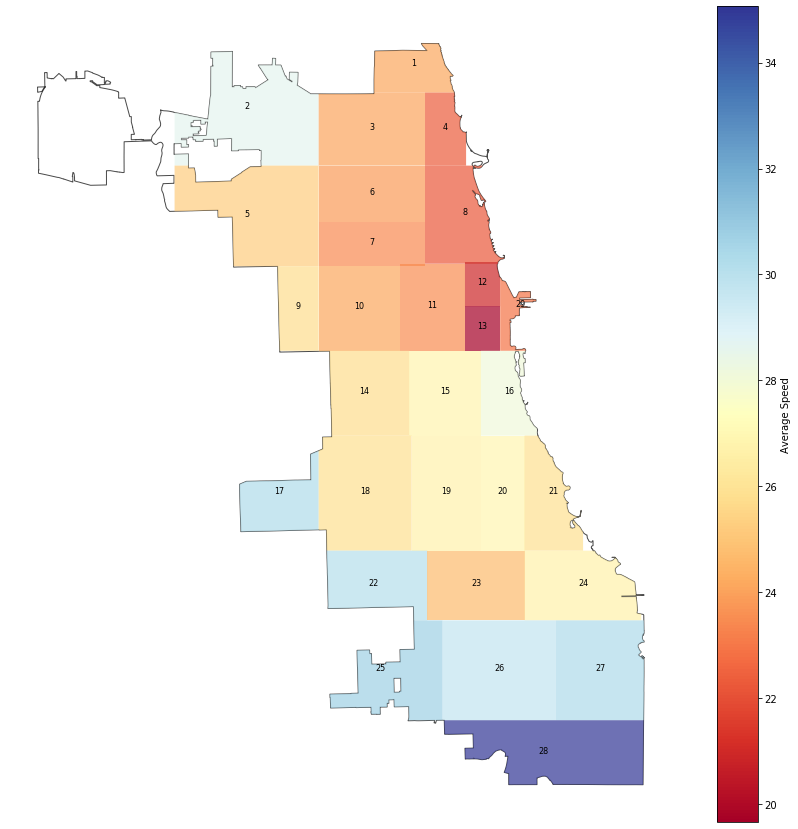

In [42]:
#colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'coolwarm', 'RdYlBu', 'YlOrRd', 'YlGnBu']

ax = basemap_gdf.plot(edgecolor='black', facecolor ="none", linewidth=1, alpha=0.7, figsize=(15, 15))
ax.set_axis_off()

# Plot the heatmap based on 'avg_speed'
heatmap = overlay_result.plot(
    ax=ax,
    column='avg_speed',  # Column containing the data for coloring
    cmap='RdYlBu',      # Colormap (choose one that suits your preference)
    linewidth=0.5,
    alpha=0.7,
    legend=True,          # Show legend
    legend_kwds={'label': "Average Speed"}, # Legend label
    
)

# Add labels for each region from the rectangles
for _, row in geo_tdf.iterrows():
    ax.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        f"{row['REGION_ID']}",
        fontsize=8,
        ha='center'
    )

# Show the plot
plt.show()


## Crash Data Analysis

In [43]:
cdf.show(1, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------
 CRASH_DATE              | 2023-07-29 14:45:00                    
 LATITUDE                | 41.854120263                           
 LONGITUDE               | -87.665902343                          
 CRASH_HOUR              | 14                                     
 CRASH_DAY_OF_WEEK       | 7                                      
 FIRST_CRASH_TYPE        | PARKED MOTOR VEHICLE                   
 PRIM_CONTRIBUTORY_CAUSE | FAILING TO REDUCE SPEED TO AVOID CRASH 
 WEATHER_CONDITION       | CLEAR                                  
 ROADWAY_SURFACE_COND    | DRY                                    
 LIGHTING_CONDITION      | DAYLIGHT                               
only showing top 1 row



In [44]:
## General Analysis 
## Crash Type, Cause, Weather, Roadway, Lighting

cdf.groupBy("FIRST_CRASH_TYPE").count().sort(desc("count")).show(20, truncate=False)
cdf.groupBy("PRIM_CONTRIBUTORY_CAUSE").count().sort(desc("count")).show(40, truncate=False)
cdf.groupBy("WEATHER_CONDITION").count().sort(desc("count")).show(20, truncate=False)
cdf.groupBy("ROADWAY_SURFACE_COND").count().sort(desc("count")).show(20, truncate=False)
cdf.groupBy("LIGHTING_CONDITION").count().sort(desc("count")).show(20, truncate=False)



+----------------------------+------+
|FIRST_CRASH_TYPE            |count |
+----------------------------+------+
|PARKED MOTOR VEHICLE        |146594|
|REAR END                    |132861|
|SIDESWIPE SAME DIRECTION    |91335 |
|TURNING                     |89842 |
|ANGLE                       |67902 |
|FIXED OBJECT                |30669 |
|PEDESTRIAN                  |14980 |
|PEDALCYCLIST                |10062 |
|SIDESWIPE OPPOSITE DIRECTION|8587  |
|REAR TO FRONT               |7235  |
|OTHER OBJECT                |6464  |
|HEAD ON                     |5244  |
|REAR TO SIDE                |4335  |
|OTHER NONCOLLISION          |1938  |
|REAR TO REAR                |1528  |
|ANIMAL                      |464   |
|OVERTURNED                  |404   |
|TRAIN                       |37    |
+----------------------------+------+

+--------------------------------------------------------------------------------+------+
|PRIM_CONTRIBUTORY_CAUSE                                                 

### Temporal Analysis

In [45]:
tempcdf1 = cdf.groupBy("CRASH_HOUR").count().sort(asc("CRASH_HOUR"))
tempcdf1.show(24, truncate=False)

+----------+-----+
|CRASH_HOUR|count|
+----------+-----+
|0         |14230|
|1         |12126|
|2         |10277|
|3         |8418 |
|4         |7441 |
|5         |8576 |
|6         |13154|
|7         |25236|
|8         |31815|
|9         |28006|
|10        |28184|
|11        |31569|
|12        |36417|
|13        |37373|
|14        |41371|
|15        |47631|
|16        |47460|
|17        |45880|
|18        |37767|
|19        |28181|
|20        |23023|
|21        |20641|
|22        |18987|
|23        |16718|
+----------+-----+



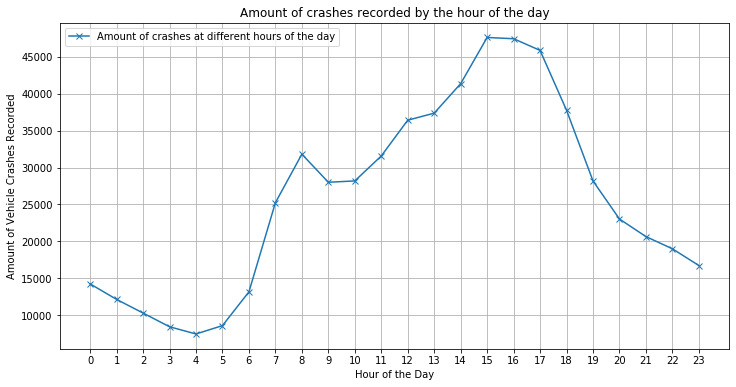

In [46]:
local_cdf1 = tempcdf1.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(local_cdf1["CRASH_HOUR"], local_cdf1["count"], marker='x', label='Amount of crashes at different hours of the day')

plt.xlabel("Hour of the Day")
plt.ylabel("Amount of Vehicle Crashes Recorded")
plt.title("Amount of crashes recorded by the hour of the day")
plt.xticks(local_cdf1["CRASH_HOUR"])
plt.legend()
plt.grid(True)
plt.show()

In [47]:
tempcdf2 = cdf.groupBy("CRASH_DAY_OF_WEEK").count().sort(asc("CRASH_DAY_OF_WEEK"))
tempcdf2.show(24, truncate=False)

+-----------------+------+
|CRASH_DAY_OF_WEEK|count |
+-----------------+------+
|1                |78378 |
|2                |85163 |
|3                |87733 |
|4                |87213 |
|5                |88884 |
|6                |100566|
|7                |92544 |
+-----------------+------+



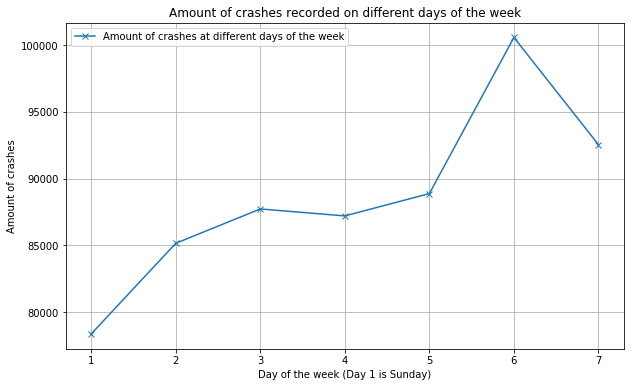

In [48]:
local_cdf2 = tempcdf2.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(local_cdf2["CRASH_DAY_OF_WEEK"], local_cdf2["count"], marker='x', label='Amount of crashes at different days of the week')

plt.xlabel("Day of the week (Day 1 is Sunday)")
plt.ylabel("Amount of crashes")
plt.title("Amount of crashes recorded on different days of the week")
plt.legend()
plt.grid(True)
plt.show()

In [49]:
tempcdf3 = cdf.groupBy(month("CRASH_DATE").alias("MONTH")).count().sort("MONTH")
tempcdf3.show(12, truncate=False)

+-----+-----+
|MONTH|count|
+-----+-----+
|1    |40853|
|2    |41763|
|3    |47852|
|4    |48905|
|5    |57231|
|6    |58062|
|7    |58430|
|8    |57889|
|9    |56695|
|10   |58505|
|11   |50489|
|12   |43807|
+-----+-----+



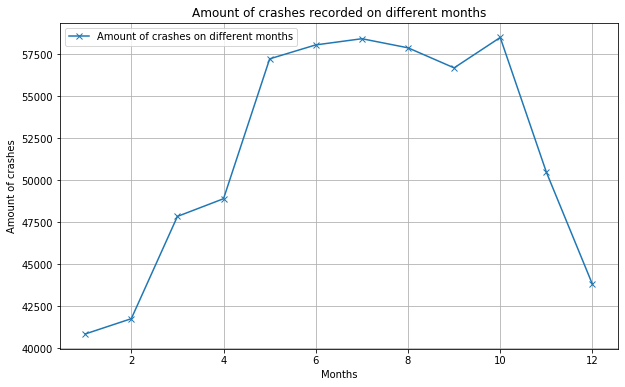

In [50]:
local_cdf3 = tempcdf3.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(local_cdf3["MONTH"], local_cdf3["count"], marker='x', label='Amount of crashes on different months')

plt.xlabel("Months")
plt.ylabel("Amount of crashes")
plt.title("Amount of crashes recorded on different months")
plt.legend()
plt.grid(True)
plt.show()

## Correlation Analysis between two datasets ##

### We will be joining dataframes together to make plots of both amount of crashes and average speed to check their correlation

In [51]:
## This function takes joined dataframes, scales the data and plots them side by side

def plot_scaled_aggregated_values(df, x_axis_column=None):
    """
    Plot scaled aggregated values for each region.

    Parameters:
    - df: PySpark DataFrame
    - x_axis_column: String, the column to be used as the x-axis (default: None, uses the first column)
    """

    # Get column names
    columns = df.columns

    # Use the first column as the x-axis if not specified
    x_axis_column = x_axis_column or columns[0]

    # Extract columns to scale (excluding the x-axis column)
    columns_to_scale = columns[1:]

    # Assemble the features into a vector column
    assembler = VectorAssembler(inputCols=columns_to_scale, outputCol="features")
    df_assembled = assembler.transform(df)

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    scaler_model = scaler.fit(df_assembled)
    scaled_df = scaler_model.transform(df_assembled)

    # Select relevant columns for plotting
    pandas_df = scaled_df.select(x_axis_column, "scaled_features").toPandas()

    # Plot the scaled aggregated values for each region
    plt.figure(figsize=(20, 8))
    for i, metric in enumerate(columns_to_scale):
        plt.plot(pandas_df[x_axis_column], pandas_df["scaled_features"].apply(lambda x: x[i]), label=f"Scaled {metric}", marker='o')

    plt.xlabel(x_axis_column)
    plt.ylabel("Scaled Aggregated Values")
    plt.title(f"Scaled Aggregated Values for Each {x_axis_column}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [52]:
## Speed and crash data frames for each hour of the week
temp1.show(5)
tempcdf1.show(5)

+----+---------+
|HOUR|avg_speed|
+----+---------+
|   0|    27.84|
|   1|    28.73|
|   2|    28.91|
|   3|    29.47|
|   4|    29.34|
+----+---------+
only showing top 5 rows

+----------+-----+
|CRASH_HOUR|count|
+----------+-----+
|         0|14230|
|         1|12126|
|         2|10277|
|         3| 8418|
|         4| 7441|
+----------+-----+
only showing top 5 rows



In [53]:
## Joined the two dataframes using the hour of the day as a common key
temp_hour_corrdf = temp1.join(tempcdf1, temp1.HOUR == tempcdf1.CRASH_HOUR, "inner").drop(col("CRASH_HOUR"))

In [54]:
temp_hour_corrdf = temp_hour_corrdf.withColumnRenamed("count", "Amount Of Crashes")
temp_hour_corrdf = temp_hour_corrdf.withColumnRenamed("avg_speed", "Estimated Average Speed")
temp_hour_corrdf.show(24)

+----+-----------------------+-----------------+
|HOUR|Estimated Average Speed|Amount Of Crashes|
+----+-----------------------+-----------------+
|   0|                  27.84|            14230|
|   1|                  28.73|            12126|
|   2|                  28.91|            10277|
|   3|                  29.47|             8418|
|   4|                  29.34|             7441|
|   5|                  27.81|             8576|
|   6|                  26.82|            13154|
|   7|                  25.36|            25236|
|   8|                  25.04|            31815|
|   9|                  25.53|            28006|
|  10|                  25.75|            28184|
|  11|                   25.5|            31569|
|  12|                  25.15|            36417|
|  13|                  24.84|            37373|
|  14|                  24.51|            41371|
|  15|                  23.94|            47631|
|  16|                  23.65|            47460|
|  17|              

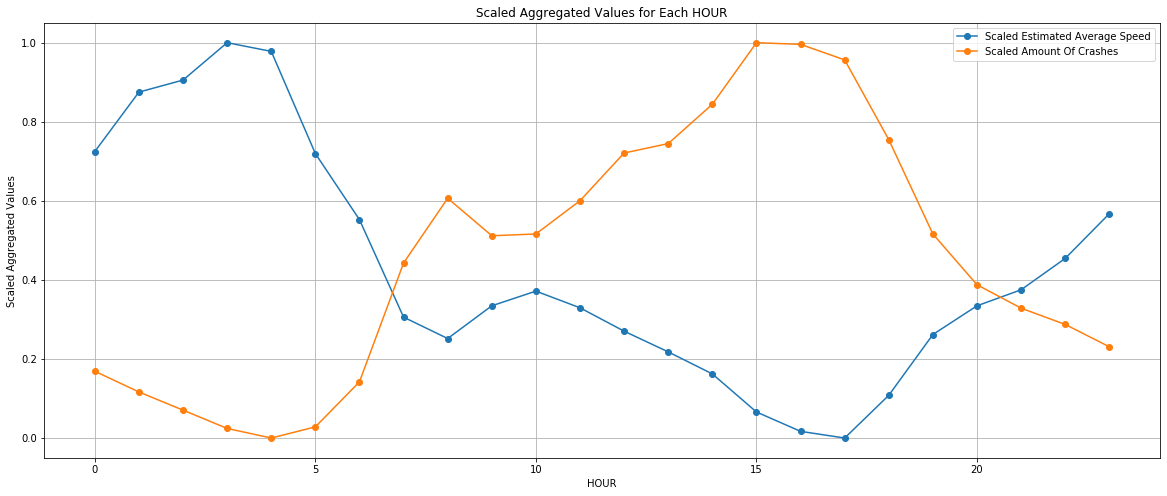

In [55]:
plot_scaled_aggregated_values(temp_hour_corrdf)

In [56]:
## AVerage Speed and crash data frames for each day of the week
tempdf1.show(7)
tempcdf2.show(7)

+-----------+-------------+
|DAY_OF_WEEK|Average Speed|
+-----------+-------------+
|          1|        26.94|
|          2|        25.61|
|          3|        25.51|
|          4|        25.46|
|          5|        25.47|
|          6|        25.49|
|          7|         26.4|
+-----------+-------------+

+-----------------+------+
|CRASH_DAY_OF_WEEK| count|
+-----------------+------+
|                1| 78378|
|                2| 85163|
|                3| 87733|
|                4| 87213|
|                5| 88884|
|                6|100566|
|                7| 92544|
+-----------------+------+



In [57]:
## Joined the two dataframes using the day of the week as a common key
temp_day_corrdf = tempdf1.join(tempcdf2, tempdf1.DAY_OF_WEEK == tempcdf2.CRASH_DAY_OF_WEEK, "inner").drop(col("CRASH_DAY_OF_WEEK"))

In [58]:
temp_day_corrdf = temp_day_corrdf.withColumnRenamed("count", "Amount Of Crashes")
temp_day_corrdf = temp_day_corrdf.withColumnRenamed("avg_speed", "Estimated Average Speed")
temp_day_corrdf.show(7)

+-----------+-------------+-----------------+
|DAY_OF_WEEK|Average Speed|Amount Of Crashes|
+-----------+-------------+-----------------+
|          1|        26.94|            78378|
|          2|        25.61|            85163|
|          3|        25.51|            87733|
|          4|        25.46|            87213|
|          5|        25.47|            88884|
|          6|        25.49|           100566|
|          7|         26.4|            92544|
+-----------+-------------+-----------------+



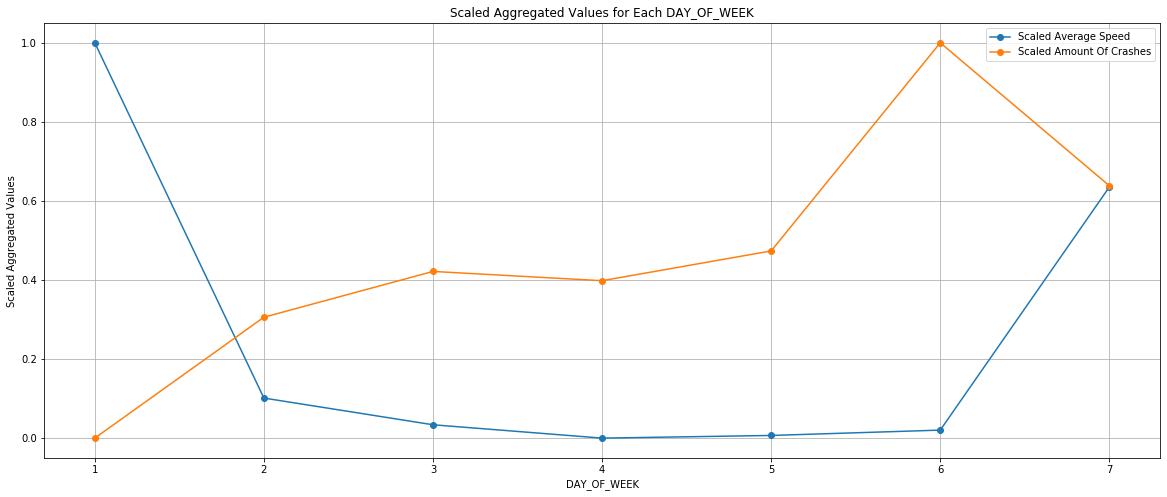

In [59]:
plot_scaled_aggregated_values(temp_day_corrdf)

In [61]:
## Average Speed and crash data frames for each month of the year
tempdf2.show(4)
tempcdf3.show(4)

+-----+-------------+
|MONTH|Average Speed|
+-----+-------------+
|    1|        25.66|
|    2|        25.72|
|    3|        25.76|
|    4|        25.83|
+-----+-------------+
only showing top 4 rows

+-----+-----+
|MONTH|count|
+-----+-----+
|    1|40853|
|    2|41763|
|    3|47852|
|    4|48905|
+-----+-----+
only showing top 4 rows



In [60]:
temp_month_corrdf = tempdf2.join(tempcdf3, tempdf2.MONTH == tempcdf3.MONTH).drop(tempcdf3.MONTH)

In [62]:
temp_month_corrdf = temp_month_corrdf.withColumnRenamed("count", "Amount Of Crashes")
temp_month_corrdf = temp_month_corrdf.withColumnRenamed("avg_speed", "Estimated Average Speed")
temp_month_corrdf.show(12)

+-----+-------------+-----------------+
|MONTH|Average Speed|Amount Of Crashes|
+-----+-------------+-----------------+
|    1|        25.66|            40853|
|    2|        25.72|            41763|
|    3|        25.76|            47852|
|    4|        25.83|            48905|
|    5|        25.87|            57231|
|    6|        25.77|            58062|
|    7|        25.89|            58430|
|    8|        25.85|            57889|
|    9|        25.81|            56695|
|   10|        25.76|            58505|
|   11|        26.14|            50489|
|   12|        25.92|            43807|
+-----+-------------+-----------------+



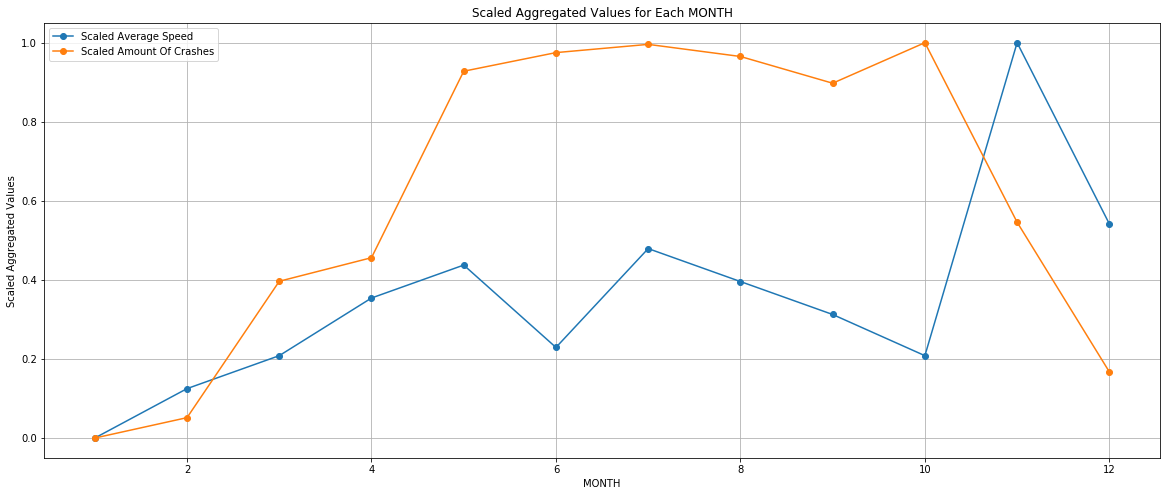

In [63]:
plot_scaled_aggregated_values(temp_month_corrdf)

### Correlated Spatial Analysis 

#### Amount of Crashes in each Region

In [64]:
# Convert the crash DataFrame to a GeoDataFrame with Point geometries
temp_select = cdf.select("LATITUDE", "LONGITUDE").toPandas()
geo_cdf = gpd.GeoDataFrame(temp_select, geometry=gpd.points_from_xy(temp_select.LONGITUDE, temp_select.LATITUDE))
geo_cdf.drop(["LATITUDE", "LONGITUDE"], inplace=True, axis=1)
geo_cdf.set_crs(geo_tdf.crs, inplace = True)
geo_cdf.head()


,geometry
0,POINT (-87.66590 41.85412)
1,POINT (-87.76188 41.94298)
2,POINT (-87.59421 41.80978)
3,POINT (-87.69664 41.89922)
4,POINT (-87.58595 41.74415)


In [65]:
geo_tdf.head()  #Geoframe for the region and avg speed

,REGION_ID,REGION,avg_speed,geometry
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026..."
1,2,Far North West,28.64,"POLYGON ((-87.84621 42.01910, -87.74746 42.019..."
2,3,North Park-Albany-Linconl Sq,24.09,"POLYGON ((-87.74746 41.99795, -87.67459 41.997..."
3,4,Edge Water-Uptown,22.35,"POLYGON ((-87.67459 41.99795, -87.64644 41.997..."
4,5,Dunning-Portage-Belmont Cragn,25.21,"POLYGON ((-87.84621 41.96067, -87.74746 41.960..."


In [66]:
# Perform a spatial join between crash_gdf and region_gdf, basically join the geoframes to find out which of the crash locations are in a region boundary
crash_region_join = geo_tdf.sjoin(geo_cdf, predicate="contains")
crash_region_join.head()

,REGION_ID,REGION,avg_speed,geometry,index_right
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026...",162272
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026...",308309
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026...",430548
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026...",172566
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026...",226339


In [69]:
# Group by region_id and count the number of crashes in each region
crash_count_per_region = crash_region_join.groupby("REGION_ID").size().reset_index(name="CRASH_COUNT")


# Merge the crash count information back into the original region GeoDataFrame
new_gdf = geo_tdf.merge(crash_count_per_region, on="REGION_ID", how="left")

crash_count_per_region.head() #amount of crashes for each region

,REGION_ID,CRASH_COUNT
0,1,13204
1,2,19819
2,3,25780
3,4,15076
4,5,34252


In [70]:
display(new_gdf)

,REGION_ID,REGION,avg_speed,geometry,CRASH_COUNT
0,1,Rogers Park - West Ridge,24.15,"POLYGON ((-87.70964 42.02644, -87.65456 42.026...",13204
1,2,Far North West,28.64,"POLYGON ((-87.84621 42.01910, -87.74746 42.019...",19819
2,3,North Park-Albany-Linconl Sq,24.09,"POLYGON ((-87.74746 41.99795, -87.67459 41.997...",25780
3,4,Edge Water-Uptown,22.35,"POLYGON ((-87.67459 41.99795, -87.64644 41.997...",15076
4,5,Dunning-Portage-Belmont Cragn,25.21,"POLYGON ((-87.84621 41.96067, -87.74746 41.960...",34252
5,6,Irving Park-Avondale-North Ctr,23.82,"POLYGON ((-87.74746 41.96067, -87.67459 41.960...",25425
6,7,Hermosa-Logan Square,23.44,"POLYGON ((-87.74746 41.93184, -87.67459 41.931...",25725
7,8,Lincoln Park-Lake View,22.21,"POLYGON ((-87.67459 41.96067, -87.61911 41.960...",29784
8,9,Austin,25.78,"POLYGON ((-87.77595 41.90927, -87.74746 41.909...",17117
9,10,Humboldt-Garfield Prk E/W,24.12,"POLYGON ((-87.74746 41.90927, -87.69162 41.909...",37569


In [71]:
# Convert Geodataframe back to spark dataframe
temp_df = new_gdf.drop(['REGION','geometry'], axis=1)
corrdf = spark.createDataFrame(temp_df)
corrdf.show(29)


+---------+---------+-----------+
|REGION_ID|avg_speed|CRASH_COUNT|
+---------+---------+-----------+
|        1|    24.15|      13204|
|        2|    28.64|      19819|
|        3|    24.09|      25780|
|        4|    22.35|      15076|
|        5|    25.21|      34252|
|        6|    23.82|      25425|
|        7|    23.44|      25725|
|        8|    22.21|      29784|
|        9|    25.78|      17117|
|       10|    24.12|      37569|
|       11|    23.47|      32825|
|       12|    20.93|      19596|
|       13|    19.67|      23696|
|       14|    25.78|      25108|
|       15|    26.88|      20672|
|       16|    28.09|      14449|
|       17|    30.31|       7379|
|       18|    25.83|      43009|
|       19|    26.73|      24880|
|       20|    26.89|      20616|
|       21|    25.85|      18444|
|       22|    30.11|      12643|
|       23|    24.68|      28837|
|       24|    26.69|      21682|
|       25|    30.78|      10457|
|       26|    29.72|      23474|
|       27|   

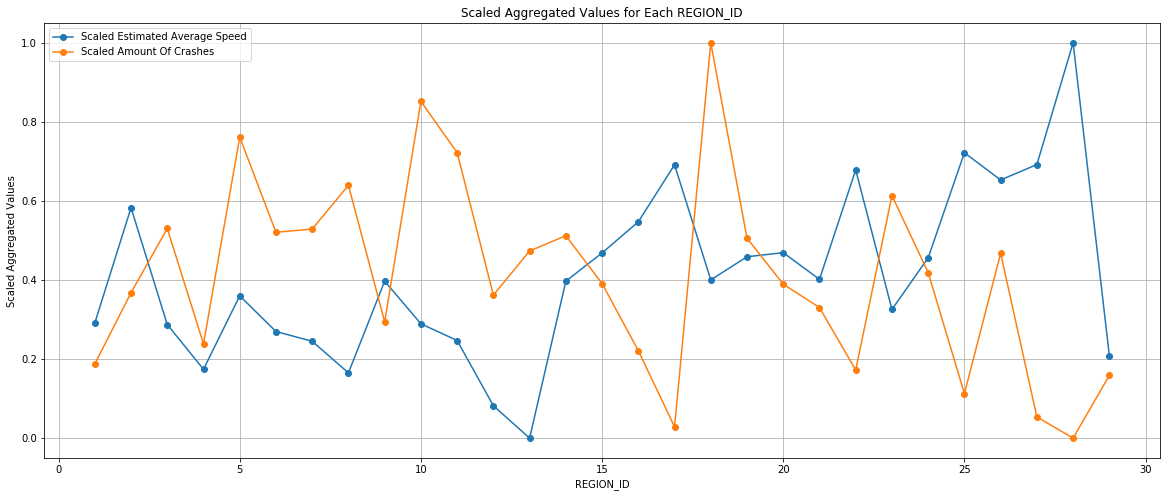

In [72]:
corrdf = corrdf.withColumnRenamed("CRASH_COUNT", "Amount Of Crashes")
corrdf = corrdf.withColumnRenamed("avg_speed", "Estimated Average Speed")
plot_scaled_aggregated_values(corrdf)


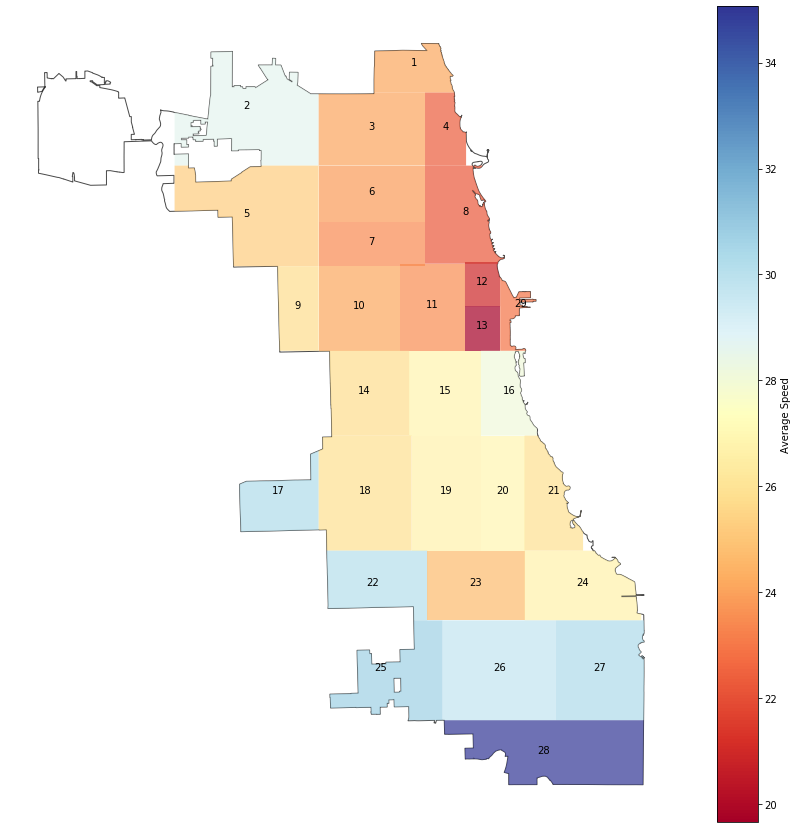

In [74]:
#colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'coolwarm', 'RdYlBu', 'YlOrRd', 'YlGnBu']

ax = basemap_gdf.plot(edgecolor='black', facecolor ="none", linewidth=1, alpha=0.7, figsize=(15, 15))
ax.set_axis_off()

overlay_result = gpd.overlay(basemap_gdf, new_gdf, how='intersection')

# Plot the heatmap based on 'avg_speed'
heatmap = overlay_result.plot(
    ax=ax,
    column='avg_speed',  # Column containing the data for coloring
    cmap='RdYlBu',      # Colormap (choose one that suits your preference)
    linewidth=0.5,
    alpha=0.7,
    legend=True,          # Show legend
    legend_kwds={'label': "Average Speed"}, # Legend label
    
)

#pip_data.plot(ax = ax, marker='*', color='green', markersize=2)

# Add labels for each region from the rectangles
for _, row in geo_tdf.iterrows():
    ax.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        f"{row['REGION_ID']}",
        fontsize=10,
        ha='center'
    )

# Show the plot
plt.show()


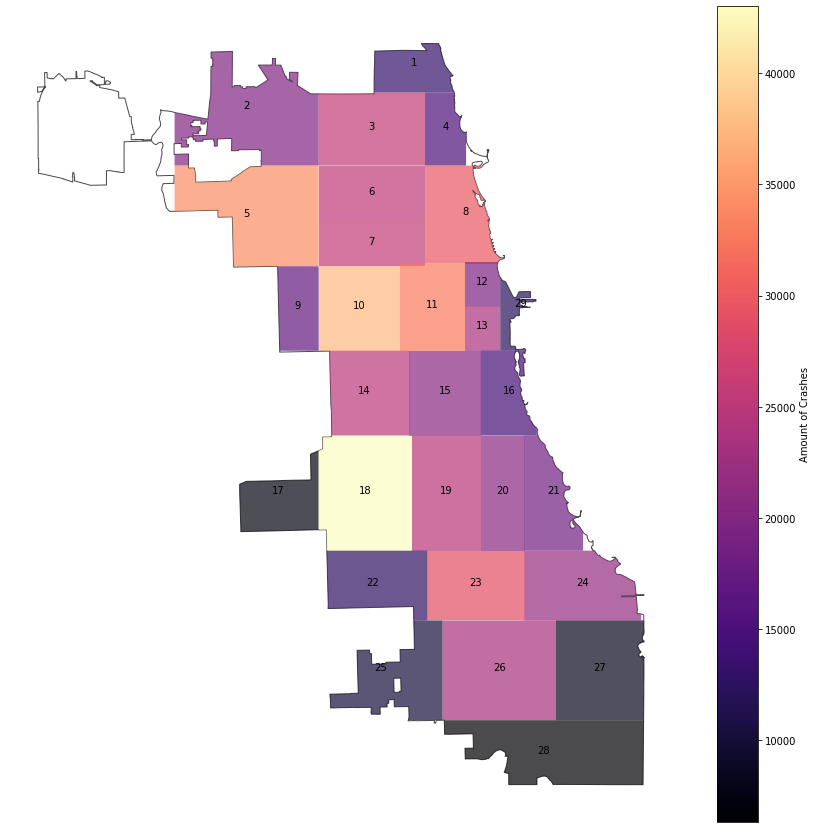

In [80]:
#colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'coolwarm', 'RdYlBu', 'YlOrRd', 'YlGnBu']

ax = basemap_gdf.plot(edgecolor='black', facecolor ="none", linewidth=1, alpha=0.7, figsize=(15, 15))
ax.set_axis_off()

overlay_result = gpd.overlay(basemap_gdf, new_gdf, how='intersection')

# Plot the heatmap based on 'avg_speed'
heatmap = overlay_result.plot(
    ax=ax,
    column='CRASH_COUNT',  # Column containing the data for coloring
    cmap='magma',      # Colormap (choose one that suits your preference)
    linewidth=0.5,
    alpha=0.7,
    legend=True,          # Show legend
    legend_kwds={'label': "Amount of Crashes"}, # Legend label
    
)

#pip_data.plot(ax = ax, marker='*', color='green', markersize=2)

# Add labels for each region from the rectangles
for _, row in geo_tdf.iterrows():
    ax.text(
        row.geometry.centroid.x,
        row.geometry.centroid.y,
        f"{row['REGION_ID']}",
        fontsize=10,
        ha='center'
    )

# Show the plot
plt.show()


## Analysis End. Shuffling and splitting data to be submitted

In [94]:
shuffledTDF = tdf.orderBy(rand())
shuffledCDF = cdf.orderBy(rand())

n = 1000000
m = 500000
shuffledTDF = shuffledTDF.limit(n)
shuffledCDF = shuffledCDF.limit(m)

In [95]:
shuffledTDF.write.parquet('/ece552project/trafficcongestion.parquet')
shuffledCDF.write.parquet('/ece552project/crashes.parquet')

In [97]:
print(shuffledTDF.count())
print(shuffledCDF.count())

1000000
500000


In [96]:
shuffledTDF.show(1, vertical=True)
shuffledCDF.show(1, vertical = True)

-RECORD 0--------------------------
 TIME        | 2020-11-01 03:20:42 
 REGION_ID   | 29                  
 REGION      | Downtown Lakefront  
 NORTH       | 41.911401           
 EAST        | -87.595378          
 SOUTH       | 41.866129           
 WEST        | -87.62308           
 SPEED       | 23.0                
 BUS_COUNT   | 7                   
 NUM_READS   | 108                 
 HOUR        | 3                   
 DAY_OF_WEEK | 1                   
only showing top 1 row

-RECORD 0---------------------------------------
 CRASH_DATE              | 2021-08-10 15:15:00  
 LATITUDE                | 41.766761485         
 LONGITUDE               | -87.655519972        
 CRASH_HOUR              | 15                   
 CRASH_DAY_OF_WEEK       | 3                    
 FIRST_CRASH_TYPE        | REAR END             
 PRIM_CONTRIBUTORY_CAUSE | FOLLOWING TOO CLO... 
 WEATHER_CONDITION       | CLEAR                
 ROADWAY_SURFACE_COND    | DRY                  
 LIGHTING_CONDITIO